In [ ]:
import numpy as np
import os
import pandas as pd
from typing import Dict, Tuple
import time
import odor_stat_calculations as osc
from cosmos_tracking import CosmosFast
import matplotlib.pyplot as plt 
from cfd_rigolli import Cfd_rigolli
from cfd_rigolli import Cfd_rigolli_BDCATS
from mpl_toolkits.axes_grid1 import make_axes_locatable


%load_ext autoreload
%autoreload 2

In [2]:
class SurgeCastAgent:
    def __init__(self, tau=0.42, noise=1.9, bias=0.25, threshold=4.5,
                 hit_trigger='peak', surge_amp=2.0, tau_surge=0.5,
                 cast_freq=1.0, cast_width=0.8, bounds=None):
        self.tau = tau
        self.noise = noise
        self.bias = bias
        self.threshold = threshold
        self.hit_trigger = hit_trigger
        self.surge_amp = surge_amp
        self.tau_surge = tau_surge
        self.cast_freq = cast_freq
        self.cast_width = cast_width
        self.bounds = bounds
        self.surge_amp_ = surge_amp / (tau_surge * np.exp(-1))

    def reflect_if_out_of_bounds(self, v: np.ndarray, x: np.ndarray):
        if self.bounds is None:
            return v, x
        v_new = v.copy()
        x_new = x.copy()
        for dim in range(2):
            if x[dim] < self.bounds[dim][0]:
                v_new[dim] *= -1
                x_new[dim] = 2*self.bounds[dim][0] - x[dim]
            elif x[dim] > self.bounds[dim][1]:
                v_new[dim] *= -1
                x_new[dim] = 2*self.bounds[dim][1] - x[dim]
        return v_new, x_new
    
def tracking(
    predictor,
    bounds,
    start_pos,
    target_pos,
    surge_agent,
    plume_timeout,
    closest_to_source,
    duration, dt
):
    dt = dt
    n_steps = int(duration / dt)

    # Source coordinates
    source_x = target_pos[0]
    source_y = target_pos[1]

    # This will become True once we decide we've "passed" the source
    passed_source = False
    
    # Casting delay
    casting_delay = 1.0

    ts = np.arange(n_steps)*dt
    odors = np.zeros(n_steps)
    surges = np.zeros(n_steps)
    bs = np.zeros((n_steps, 2))
    vs = np.zeros((n_steps, 2))
    xs = np.zeros((n_steps, 2))
    hits = np.zeros(n_steps)

    velocities = np.zeros((n_steps, 2))
    speeds = np.zeros(n_steps)
    accelerations = np.zeros(n_steps)
    angles = np.zeros(n_steps)
    angular_velocities = np.zeros(n_steps)
    crosswind_distances = np.zeros(n_steps)
    upwind_distances = np.zeros(n_steps)
    dist_to_targets = np.zeros(n_steps)
    time_since_last_hits = np.zeros(n_steps)
    casting_phases = np.zeros(n_steps)
    local_curvatures = np.zeros(n_steps)
    is_casting = np.zeros(n_steps)
    is_surging = np.zeros(n_steps)
    in_odor = np.zeros(n_steps)

    x = start_pos.copy()
    v = np.zeros(2)
    last_hit_time = 0.0
    last_odor = 0.0
    hit_occurred = False
    prev_angle = 0.0
    
    # Pure upwind initial bias
    upwind = np.array([-1.0, 0.0])
    b = upwind * surge_agent.bias

    for t_ctr in range(n_steps):
        # 1) Get odor from predictor
        current_odor = predictor.step_update(x[0], x[1], dt)

        # 2) Check if we've passed the source (adjust logic if wind flows differently)
        if (x[0] < source_x):

            passed_source = True

        # --------------------------------------------------
        # NEW: Force the odor to zero once passed_source == True
        # --------------------------------------------------
        if passed_source:
            current_odor = 0.0
        
        # Store final odor value (possibly forced to zero)
        odors[t_ctr] = current_odor

        # 3) Now define whether we're in odor
        currently_in_odor = (current_odor >= surge_agent.threshold)
        in_odor[t_ctr] = 1 if currently_in_odor else 0
        
        # Update last_hit_time if in odor
        if currently_in_odor:
            last_hit_time = t_ctr * dt

        # 4) Whiff detection (skip if passed_source == True, because odor=0)
        if not passed_source:
            if surge_agent.hit_trigger == 'peak':
                if currently_in_odor:
                    if (current_odor <= last_odor) and (not hit_occurred):
                        hits[t_ctr] = 1
                        hit_occurred = True
                    last_odor = current_odor
                else:
                    last_odor = 0
                    hit_occurred = False
            elif surge_agent.hit_trigger == 'threshold':
                hits[t_ctr] = 1 if currently_in_odor else 0
        # else: do nothing once passed_source is True

        if t_ctr > 0:
            # Noise
            eta = np.random.normal(0, surge_agent.noise, 2)
            time_since_hit = t_ctr * dt - last_hit_time
            time_since_last_hits[t_ctr] = time_since_hit

            # Distance to target
            to_target = target_pos - x
            dist_to_target = np.linalg.norm(to_target)
            if dist_to_target < closest_to_source:
                print(f"Target reached at {x}")
                break

            # Behavior selection
            if currently_in_odor:
                upwind_dir = np.array([-1.0, 0.0])
                surge_strength = surge_agent.surge_amp * 5.0
                v = upwind_dir * surge_strength
                # Optionally add noise
                v += eta * dt

                is_surging[t_ctr] = 1
                is_casting[t_ctr] = 0

                x += v * dt

            elif time_since_hit > casting_delay:
                cast_freq = surge_agent.cast_freq
                cast_phase = np.sin(2 * np.pi * cast_freq * ts[t_ctr])
                casting_phases[t_ctr] = cast_phase

                cast_width_factor = min(6.0, 1.0 + 0.8*(time_since_hit / plume_timeout))
                cast_width = surge_agent.cast_width * cast_width_factor

                crosswind = np.array([0.0, cast_phase * cast_width])
                upwind = np.array([-0.1, 0.0])
                
                b = upwind + crosswind
                is_casting[t_ctr] = 1
                is_surging[t_ctr] = 0

                v += (dt / surge_agent.tau)*(-v + eta + b)
                x += v * dt

            else:
                surge_decay = max(0.1, 1.0 - (time_since_hit / casting_delay))
                surge_direction = np.array([-1.0, 0.0])
                b = surge_direction * surge_agent.bias * 3.0 * surge_decay

                is_casting[t_ctr] = 0
                is_surging[t_ctr] = 1

                v += (dt / surge_agent.tau)*(-v + eta + b)
                x += v * dt

            # Reflect if bounds exist
            if bounds is not None:
                v, x = surge_agent.reflect_if_out_of_bounds(v, x)

            # Metrics
            velocities[t_ctr] = v
            speeds[t_ctr] = np.linalg.norm(v)
            if t_ctr > 1:
                accelerations[t_ctr] = (speeds[t_ctr] - speeds[t_ctr - 1]) / dt
            
            current_angle = np.arctan2(v[1], v[0])
            angles[t_ctr] = current_angle
            angle_diff = np.arctan2(
                np.sin(current_angle - prev_angle),
                np.cos(current_angle - prev_angle)
            )
            angular_velocities[t_ctr] = angle_diff / dt
            prev_angle = current_angle
            
            crosswind_distances[t_ctr] = abs(x[1] - target_pos[1])
            upwind_distances[t_ctr] = abs(x[0] - target_pos[0])
            dist_to_targets[t_ctr] = dist_to_target

            if t_ctr >= 2:
                pos_window = xs[t_ctr - 2 : t_ctr + 1]
                dx = np.gradient(pos_window[:, 0])
                dy = np.gradient(pos_window[:, 1])
                ddx = np.gradient(dx)
                ddy = np.gradient(dy)
                denom = (dx**2 + dy**2)**1.5 + 1e-10
                curvature = np.abs(dx*ddy - dy*ddx) / denom
                local_curvatures[t_ctr] = np.mean(curvature)

        bs[t_ctr] = b
        vs[t_ctr] = v
        xs[t_ctr] = x

    # Trim if ended early
    if t_ctr < (n_steps - 1):
        trim_slice = slice(0, t_ctr + 1)
        ts = ts[trim_slice]
        xs = xs[trim_slice]
        bs = bs[trim_slice]
        vs = vs[trim_slice]
        odors = odors[trim_slice]
        hits = hits[trim_slice]
        surges = surges[trim_slice]
        velocities = velocities[trim_slice]
        speeds = speeds[trim_slice]
        accelerations = accelerations[trim_slice]
        angles = angles[trim_slice]
        angular_velocities = angular_velocities[trim_slice]
        crosswind_distances = crosswind_distances[trim_slice]
        upwind_distances = upwind_distances[trim_slice]
        dist_to_targets = dist_to_targets[trim_slice]
        time_since_last_hits = time_since_last_hits[trim_slice]
        casting_phases = casting_phases[trim_slice]
        local_curvatures = local_curvatures[trim_slice]
        is_casting = is_casting[trim_slice]
        is_surging = is_surging[trim_slice]
        in_odor = in_odor[trim_slice]

    trajectory_df = pd.DataFrame({
        'time': ts,
        'x': xs[:, 0],
        'y': xs[:, 1],
        'vx': velocities[:, 0],
        'vy': velocities[:, 1],
        'speed': speeds,
        'acceleration': accelerations,
        'heading_angle': angles,
        'angular_velocity': angular_velocities,
        'crosswind_dist': crosswind_distances,
        'upwind_dist': upwind_distances,
        'dist_to_target': dist_to_targets,
        'time_since_whiff': time_since_last_hits,
        'casting_phase': casting_phases,
        'path_curvature': local_curvatures,
        'is_casting': is_casting,
        'is_surging': is_surging,
        'odor': odors,
        'whiff': hits,
        'in_odor': in_odor,
        'bias_force_x': bs[:, 0],
        'bias_force_y': bs[:, 1]
    })

    # Remove final row if it's exactly x=y=0
    if len(trajectory_df) > 0 \
       and trajectory_df.iloc[-1]['x'] == 0 \
       and trajectory_df.iloc[-1]['y'] == 0:
        trajectory_df = trajectory_df.iloc[:-1]
    return trajectory_df


[30.  1.]

Running simulation 50/1 [30.  1.]:
Simulation completed in 1.04 seconds
Number of steps: 6000
Number of odor detections: 14
Final distance to target: 3.17


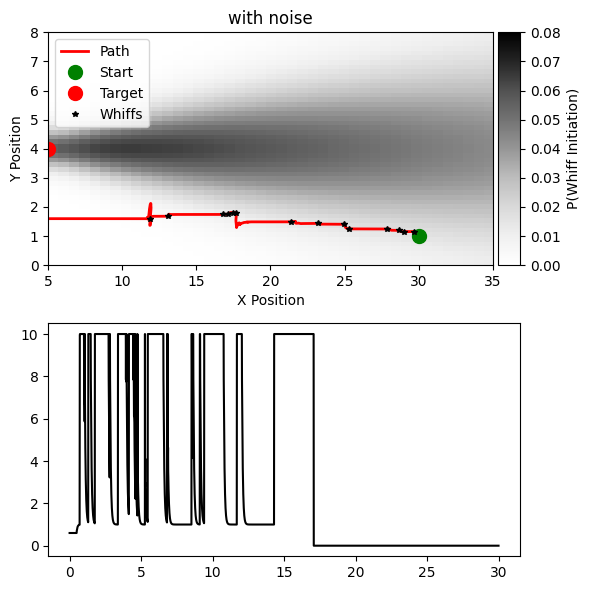

In [6]:

if __name__ == "__main__":
    # Setup simulation parameters - Now with no bounds
    bounds = None  # Remove bounds completely
    # start_pos = np.array([13.0, 6.0])  # Starting in the middle
    target_pos = np.array([5.0, 4.0])   # Target on the left side
    
    surge_agent = SurgeCastAgent(
        tau=0.1,
        noise=2.0,
        bias=0.1,         # Reduced bias since it's now purely directional
        threshold=6.5,
        hit_trigger='peak',
        surge_amp=0.5,
        tau_surge=2.0,
        cast_freq=1.0,    # Casting frequency
        cast_width=2.0,   # Casting width
        bounds=None       # No bounds
    )
    
    # No target weight needed anymore
    # target_weight = 0
    plume_timeout = 10.0
    closest_to_source = 0.2
    sim_duration = 30.0
    dt=0.005
    
    # Load predictor data (same as in original code)
    dirname = 'data/rigolli/'
    hmap_data = np.load(str(dirname) + "hmap.npz")
    fdf = pd.read_hdf(str(dirname) + 'whiff.h5')
    fdf_nowhiff = pd.read_hdf(str(dirname) + 'nowhiff.h5')

    # Create predictor 
    predictor = CosmosFast(
        fitted_p_heatmap=hmap_data['fitted_p_heatmap'],
        xedges=hmap_data['xedges'],
        yedges=hmap_data['yedges'],
        fdf=fdf,
        fdf_nowhiff=fdf_nowhiff
    )
    
    # Run the tracking simulation
    # print(f"Running simulation from position {start_pos}:")
    
    # Record starting time
    start_wall = time.time()
    
    x_bounds = (25, 35)
    y_bounds = (1, 7)
    
    # Number of random starting points
    num_starting_points = 1
    
    # Generate random integer starting points within bounds
    np.random.seed(42)  # For reproducibility
    random_x = np.random.randint(x_bounds[0], x_bounds[1] + 1, num_starting_points)
    random_y = np.random.randint(y_bounds[0], y_bounds[1] + 1, num_starting_points)

    # Run the tracking simulation
    # trajectory_df = tracking(
    #     predictor, bounds, start_pos, target_pos, surge_agent,
    #      plume_timeout, closest_to_source, sim_duration
    # )
    starting_positions = []
    for i in range(num_starting_points):
        # start_pos = np.array([float(random_x[i]), float(random_y[i])])
        start_pos=np.array([30.0, 1.0])
        print(start_pos)
        starting_positions.append(start_pos.copy())
        
        print(f"\nRunning simulation {i+50}/{str(num_starting_points)} {start_pos}:")
        
        # Record starting wall-clock time and CPU times for this iteration
        # start_wall = time.time()
        # start_cpu = os.times()
        trajectory_df=pd.DataFrame()
        # Run the tracking simulation
        trajectory_df = tracking(
            predictor, bounds, start_pos, target_pos, surge_agent,
            plume_timeout, closest_to_source, sim_duration, dt 
        )
        # trajectory_df.to_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/april3/plot_trajs/cosmos'+str(i+1)+'_40_1_60.h5', mode='w',key='trajector_df')
        
        fig, (ax,ax1) = plt.subplots(2,1,figsize=(6, 6))

        fitted_p_heatmap = hmap_data['fitted_p_heatmap']
        xedges = hmap_data['xedges']
        yedges = hmap_data['yedges']

        # Plot the heatmap with lighter blue colormap and lower max value for better contrast
        cax = ax.imshow(
            fitted_p_heatmap.T,
            origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            cmap='Greys',  # Using Blues colormap
            vmin=0, 
            vmax=0.08,    # Lower max value to make the heatmap lighter
            aspect='auto',
            alpha=1      # Make the heatmap slightly transparent
        )

        # Add colorbar
        divider = make_axes_locatable(ax)
        cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(cax, cax=cbar_ax, label='P(Whiff Initiation)')

        # Overlay trajectory on the heatmap
        ax.plot(trajectory_df.x, trajectory_df.y, c='red', label='Path', linewidth=2)
        ax.plot(start_pos[0], start_pos[1], 'go', label='Start', markersize=10)
        ax.plot(target_pos[0], target_pos[1], 'ro', label='Target', markersize=10)

        # Plot odor detections
        whiff_rows = trajectory_df[trajectory_df.whiff == 1]
        if not whiff_rows.empty:
            ax.plot(whiff_rows.x, whiff_rows.y, 'k*', label='Whiffs', markersize=4)

        # # Set consistent bounds
        ax.set_xlim(5,35)
        # ax.set_ylim(bounds[1])

        # Add labels and title
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_title('with noise')
        ax.legend(loc='upper left')
        ax.grid(False)
        ax1.plot(trajectory_df.time, trajectory_df.odor, c='black')
        # Print summary
        print(f"Simulation completed in {time.time() - start_wall:.2f} seconds")
        print(f"Number of steps: {len(trajectory_df)}")
        print(f"Number of odor detections: {whiff_rows.shape[0]}")
        print(f"Final distance to target: {trajectory_df.iloc[-1]['dist_to_target']:.2f}")
        # ax.invert_xaxis()
        # ax1.invert_yaxis()
        plt.tight_layout()
    

### Rigolli Tracker

In [7]:
class CfdOdorPredictor:
    def __init__(self, cfd_simulator, scale_data_fn):
        self.cfd = cfd_simulator
        self.scale_data = scale_data_fn
        self.config = type('Config', (), {
            'warmup_steps': 0,
            'rows_per_second': 200
        })()

    def get_wind_at_position(self, pos: Tuple[float, float], time: float) -> Tuple[float, float, float]:
        return self.cfd.get_wind_at_position_and_time(pos, time)

    def get_odor_at_position(self, pos: Tuple[float, float], time: float) -> float:
        odor = self.cfd.get_odor_at_position_and_time(pos, time)
        return odor


def scale_data(data):
    min_val = 0
    max_val = 16
    return (((data - min_val) / (max_val - min_val)) * 10)


def cfd_tracking(
    cfd_predictor,
    bounds,
    start_pos,
    target_pos,
    surge_agent,
    plume_timeout,
    closest_to_source,
    duration,
    dt
):
    dt = dt
    n_steps = int(duration / dt)

    # Source coordinates
    source_x = target_pos[0]
    source_y = target_pos[1]

    # This will become True once we decide we've "passed" the source
    passed_source = False
    
    # Casting delay
    casting_delay = 1.0

    ts = np.arange(n_steps)*dt
    odors = np.zeros(n_steps)
    surges = np.zeros(n_steps)
    bs = np.zeros((n_steps, 2))
    vs = np.zeros((n_steps, 2))
    xs = np.zeros((n_steps, 2))
    hits = np.zeros(n_steps)

    velocities = np.zeros((n_steps, 2))
    speeds = np.zeros(n_steps)
    accelerations = np.zeros(n_steps)
    angles = np.zeros(n_steps)
    angular_velocities = np.zeros(n_steps)
    crosswind_distances = np.zeros(n_steps)
    upwind_distances = np.zeros(n_steps)
    dist_to_targets = np.zeros(n_steps)
    time_since_last_hits = np.zeros(n_steps)
    casting_phases = np.zeros(n_steps)
    local_curvatures = np.zeros(n_steps)
    is_casting = np.zeros(n_steps)
    is_surging = np.zeros(n_steps)
    in_odor = np.zeros(n_steps)

    x = start_pos.copy()
    v = np.zeros(2)
    last_hit_time = 0.0
    last_odor = 0.0
    hit_occurred = False
    prev_angle = 0.0
    
    # Pure upwind initial bias
    upwind = np.array([-1.0, 0.0])
    b = upwind * surge_agent.bias

    for t_ctr in range(n_steps):
        # 1) Get odor from CFD predictor
        raw_odor = cfd_predictor.get_odor_at_position(tuple(x), ts[t_ctr])
        current_odor = cfd_predictor.scale_data(raw_odor)

        # 2) Check if we've passed the source (adjust logic if wind flows differently)
        if x[0] <= source_x:
            passed_source = True

        # 3) Force the odor to zero once passed_source == True
        if passed_source:
            current_odor = 0.0
        
        # Store final odor value (possibly forced to zero)
        odors[t_ctr] = current_odor

        # 4) Now define whether we're in odor
        currently_in_odor = (current_odor >= surge_agent.threshold)
        in_odor[t_ctr] = 1 if currently_in_odor else 0
        
        # Update last_hit_time if in odor
        if currently_in_odor:
            last_hit_time = t_ctr * dt

        # 5) Whiff detection (skip if passed_source == True, because odor=0)
        if not passed_source:
            if surge_agent.hit_trigger == 'peak':
                if currently_in_odor:
                    if (current_odor <= last_odor) and (not hit_occurred):
                        hits[t_ctr] = 1
                        hit_occurred = True
                    last_odor = current_odor
                else:
                    last_odor = 0
                    hit_occurred = False
            elif surge_agent.hit_trigger == 'threshold':
                hits[t_ctr] = 1 if currently_in_odor else 0

        if t_ctr > 0:
            # Noise
            eta = np.random.normal(0, surge_agent.noise, 2)
            time_since_hit = t_ctr * dt - last_hit_time
            time_since_last_hits[t_ctr] = time_since_hit

            # Distance to target
            to_target = target_pos - x
            dist_to_target = np.linalg.norm(to_target)
            if dist_to_target < closest_to_source:
                print(f"Target reached at {x}")
                break

            # Behavior selection
            if currently_in_odor:
                upwind_dir = np.array([-1.0, 0.0])
                surge_strength = surge_agent.surge_amp * 5.0
                v = upwind_dir * surge_strength
                # Optionally add noise
                v += eta * dt

                is_surging[t_ctr] = 1
                is_casting[t_ctr] = 0

                x += v * dt

            elif time_since_hit > casting_delay:
                cast_freq = surge_agent.cast_freq
                cast_phase = np.sin(2 * np.pi * cast_freq * ts[t_ctr])
                casting_phases[t_ctr] = cast_phase

                cast_width_factor = min(6.0, 1.0 + 0.8*(time_since_hit / plume_timeout))
                cast_width = surge_agent.cast_width * cast_width_factor

                crosswind = np.array([0.0, cast_phase * cast_width])
                upwind = np.array([-0.1, 0.0])
                
                b = upwind + crosswind
                is_casting[t_ctr] = 1
                is_surging[t_ctr] = 0

                v += (dt / surge_agent.tau)*(-v + eta + b)
                x += v * dt

            else:
                surge_decay = max(0.1, 1.0 - (time_since_hit / casting_delay))
                surge_direction = np.array([-1.0, 0.0])
                b = surge_direction * surge_agent.bias * 3.0 * surge_decay

                is_casting[t_ctr] = 0
                is_surging[t_ctr] = 1

                v += (dt / surge_agent.tau)*(-v + eta + b)
                x += v * dt

            # Reflect if bounds exist
            if bounds is not None:
                v, x = surge_agent.reflect_if_out_of_bounds(v, x)

            # Metrics
            velocities[t_ctr] = v
            speeds[t_ctr] = np.linalg.norm(v)
            if t_ctr > 1:
                accelerations[t_ctr] = (speeds[t_ctr] - speeds[t_ctr - 1]) / dt
            
            current_angle = np.arctan2(v[1], v[0])
            angles[t_ctr] = current_angle
            angle_diff = np.arctan2(
                np.sin(current_angle - prev_angle),
                np.cos(current_angle - prev_angle)
            )
            angular_velocities[t_ctr] = angle_diff / dt
            prev_angle = current_angle
            
            crosswind_distances[t_ctr] = abs(x[1] - target_pos[1])
            upwind_distances[t_ctr] = abs(x[0] - target_pos[0])
            dist_to_targets[t_ctr] = dist_to_target

            if t_ctr >= 2:
                pos_window = xs[t_ctr - 2 : t_ctr + 1]
                dx = np.gradient(pos_window[:, 0])
                dy = np.gradient(pos_window[:, 1])
                ddx = np.gradient(dx)
                ddy = np.gradient(dy)
                denom = (dx**2 + dy**2)**1.5 + 1e-10
                curvature = np.abs(dx*ddy - dy*ddx) / denom
                local_curvatures[t_ctr] = np.mean(curvature)

        bs[t_ctr] = b
        vs[t_ctr] = v
        xs[t_ctr] = x

    # Trim if ended early
    if t_ctr < (n_steps - 1):
        trim_slice = slice(0, t_ctr + 1)
        ts = ts[trim_slice]
        xs = xs[trim_slice]
        bs = bs[trim_slice]
        vs = vs[trim_slice]
        odors = odors[trim_slice]
        hits = hits[trim_slice]
        surges = surges[trim_slice]
        velocities = velocities[trim_slice]
        speeds = speeds[trim_slice]
        accelerations = accelerations[trim_slice]
        angles = angles[trim_slice]
        angular_velocities = angular_velocities[trim_slice]
        crosswind_distances = crosswind_distances[trim_slice]
        upwind_distances = upwind_distances[trim_slice]
        dist_to_targets = dist_to_targets[trim_slice]
        time_since_last_hits = time_since_last_hits[trim_slice]
        casting_phases = casting_phases[trim_slice]
        local_curvatures = local_curvatures[trim_slice]
        is_casting = is_casting[trim_slice]
        is_surging = is_surging[trim_slice]
        in_odor = in_odor[trim_slice]

    trajectory_df = pd.DataFrame({
        'time': ts,
        'x': xs[:, 0],
        'y': xs[:, 1],
        'vx': velocities[:, 0],
        'vy': velocities[:, 1],
        'speed': speeds,
        'acceleration': accelerations,
        'heading_angle': angles,
        'angular_velocity': angular_velocities,
        'crosswind_dist': crosswind_distances,
        'upwind_dist': upwind_distances,
        'dist_to_target': dist_to_targets,
        'time_since_whiff': time_since_last_hits,
        'casting_phase': casting_phases,
        'path_curvature': local_curvatures,
        'is_casting': is_casting,
        'is_surging': is_surging,
        'odor': odors,
        'whiff': hits,
        'in_odor': in_odor,
        'bias_force_x': bs[:, 0],
        'bias_force_y': bs[:, 1]
    })

    # Remove final row if it's exactly x=y=0
    if len(trajectory_df) > 0 \
       and trajectory_df.iloc[-1]['x'] == 0 \
       and trajectory_df.iloc[-1]['y'] == 0:
        trajectory_df = trajectory_df.iloc[:-1]
    return trajectory_df

In [ ]:
bounds = None
# start_pos = np.array([20.0, 6.0])

target_pos = np.array([5.0, 4.0])

# Create surge-cast agent
surge_agent = SurgeCastAgent(
    tau=0.1,
    noise=2.0,
    bias=0.1,         # Reduced bias since it's now purely directional
    threshold=6.5,
    hit_trigger='peak',
    surge_amp=0.5,
    tau_surge=2.0,
    cast_freq=1.0,    # Casting frequency
    cast_width=2.0,   # Casting width
    bounds=None       # No bounds
)

target_weight = 0
plume_timeout = 10.0
closest_to_source = 0.2
sim_duration = 30.0

# Define the bounds for random starting points
x_bounds = (25, 35)
y_bounds = (1, 7)
dt=0.0125
# Number of random starting points
num_starting_points = 1

# Generate random integer starting points within bounds
np.random.seed(42)  # For reproducibility
random_x = np.random.randint(x_bounds[0], x_bounds[1] + 1, num_starting_points)
random_y = np.random.randint(y_bounds[0], y_bounds[1] + 1, num_starting_points)

# Lists to store results
wall_times = []
cpu_times = []
cpu_hours_list = []
starting_positions = []

# Record starting wall-clock time and CPU times for the entire run
start_wall_total = time.time()
start_cpu_total = os.times()

# Loop over all random starting points
for i in range(num_starting_points):
    # start_pos = np.array([float(random_x[i]), float(random_y[i])])
    start_pos=np.array([30.0, 1.0])
    starting_positions.append(start_pos.copy())
    
    print(f"\nRunning simulation {i+50}/{str(num_starting_points)} from position {start_pos}:")
    new_cfd = Cfd_rigolli_BDCATS(dirname="../data/rigolli/")
    cfd_predictor = CfdOdorPredictor(new_cfd, scale_data)
    
    # Record starting wall-clock time and CPU times for this iteration
    start_wall = time.time()
    start_cpu = os.times()
    
    # Run the CFD tracking simulation
    cfd_df = cfd_tracking(cfd_predictor, bounds, start_pos, target_pos, surge_agent,
                           plume_timeout, closest_to_source, sim_duration,dt)
    
    # cfd_df.to_hdf('/home/gorilla/An/data/simulator/plot/tracking_figure/april3/plot_trajs/cfd'+str(i+1)+'_40_1_60.h5', mode='w',key='cfd_df')
        
# # Record ending times

    fig, (ax,ax1) = plt.subplots(2,1,figsize=(6, 6))


    # fitted_p_heatmap = hmap_data['fitted_p_heatmap']
    # xedges = hmap_data['xedges']
    # yedges = hmap_data['yedges']

    # Plot the heatmap with lighter blue colormap and lower max value for better contrast
    # cax = ax.imshow(
    #     fitted_p_heatmap.T,
    #     origin='lower',
    #     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    #     cmap='Blues',  # Using Blues colormap
    #     vmin=0, 
    #     vmax=0.08,    # Lower max value to make the heatmap lighter
    #     aspect='auto',
    #     alpha=1      # Make the heatmap slightly transparent
    # )

    # Add colorbar
    divider = make_axes_locatable(ax)
    cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(cax, cax=cbar_ax, label='P(Whiff Initiation)')

    # Overlay trajectory on the heatmap
    ax.plot(cfd_df.x, cfd_df.y, c='red', label='Path', linewidth=2)
    ax.plot(start_pos[0], start_pos[1], 'go', label='Start', markersize=10)
    ax.plot(target_pos[0], target_pos[1], 'ro', label='Target', markersize=10)

    # Plot odor detections
    whiff_rows = cfd_df[cfd_df.whiff == 1]
    if not whiff_rows.empty:
        ax.plot(whiff_rows.x, whiff_rows.y, 'k*', label='Whiffs', markersize=4)

    # # Set consistent bounds
    # ax.set_xlim(bounds[0])
    # ax.set_ylim(bounds[1])

    # Add labels and title
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('with noise')
    ax.legend(loc='upper right')
    ax.grid(False)
    ax1.plot(cfd_df.time,cfd_df.odor, c='black')
    ax.set_xlim(0,35)
    ax.set_ylim(0,8)
    ax.invert_xaxis()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    # Print summary
    print(f"Simulation completed in {time.time() - start_wall:.2f} seconds")
    print(f"Number of steps: {len(cfd_df)}")
    print(f"Number of odor detections: {whiff_rows.shape[0]}")
    print(f"Final distance to target: {cfd_df.iloc[-1]['dist_to_target']:.2f}")

    fig.tight_layout()
